# Berg quarry - data cleaning

## Imports

In [1]:
# Scientific packages
import pandas as pd
import numpy as np

# Operating system interaction package
import os

# Visualisation packages
import seaborn as sns
import matplotlib.pyplot as plt

# Coordinate handling package
import pyproj

# Geographical map package
import folium
from folium.features import DivIcon

In [1]:
# Local package with project specific functions
from compositional_data_kriging import borehole_analysis as bap

In [2]:
# Load jupyter extension to reload packages before executing user code.
# This is useful for local packages when code is still being changed
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload

In [3]:
# Reload all packages (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

## Files

1. collar 92 boreholes
2. survey 92 boreholes
3. geology 80 boreholes
4. washed 92 boreholes

In [4]:
# Set coordinates projections
lam72 = pyproj.Proj(init="ESRI:103300") # Lambert 72
wgs84 = pyproj.Proj(init="EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth

In [5]:
# Set directory path
path_Berg = "../_DATA/Berg_groeve/"

___

## 1&2. Berg collar and survey
* Coordinates
* Elevation
* Year

In [6]:
# Create DataFrames from csv files
df_Berg_collar = pd.read_csv(path_Berg + "Berg_collar.csv", sep=";") # Basic information
df_Berg_survey = pd.read_csv(path_Berg + "Berg_survey.csv", sep=";") # Doesn't add new information

# Drop unnecessary columns
df_Berg_collar.drop(["hole_path"], axis=1, inplace=True)
df_Berg_collar.head()

,hole_id,max_depth,x,y,z,year
0,201,42.5,238758.85,185215.33,91.50,1977
1,677_2,39.0,238919.26,185520.55,88.98,1977
2,877_3,48.0,238740.94,185498.74,89.83,1977
3,877_4,43.0,238657.28,185260.13,91.26,1977
4,977_6,45.0,238952.20,185395.71,91.26,1977


In [7]:
# Transform coordinates from Lambert72 to WGS84
Berg_lon, Berg_lat = pyproj.transform(lam72, wgs84, df_Berg_collar["x"].values, df_Berg_collar["y"].values)

In [8]:
# Change Lambert72 coordinates to WGS84 coordinates in degrees
df_Berg_collar["x"] = Berg_lat
df_Berg_collar["y"] = Berg_lon

# Rename x, y and z columns to latitude, longitude and elevation
df_Berg_collar.rename(columns={"x" : "lat", 
                               "y" : "lon", 
                               "z" : "elevation"}, inplace=True)
df_Berg_collar.head()

,hole_id,max_depth,lat,lon,elevation,year
0,201,42.5,50.970939,5.631154,91.50,1977
1,677_2,39.0,50.973657,5.633511,88.98,1977
2,877_3,48.0,50.973489,5.630967,89.83,1977
3,877_4,43.0,50.971357,5.629719,91.26,1977
4,977_6,45.0,50.972530,5.633950,91.26,1977


In [9]:
# Create map
Berg_map = folium.Map()

# Add boreholes to map
for index, row in df_Berg_collar.iterrows():
    
    # Create borehole markers
    marker = folium.features.Circle(radius=5, 
                                    location=[row["lat"], row["lon"]], 
                                    color='crimson',
                                    fill=True,
                                    fill_color='crimson',
                                    fill_opacity=1)
    # Add borehole markers to map
    marker.add_to(Berg_map)
    
    # Create borehole labels
    text = folium.Marker(location=[row["lat"], row["lon"]], 
                         popup="year: " + str(row["year"]),
                         icon=DivIcon(icon_size=(150,36), 
                                      icon_anchor=(-1,-1), 
                                      html='<div style="font-size: 8pt">' + row["hole_id"] +'</div>'))
    # Add borehole label to map
    text.add_to(Berg_map)

# Map bounding coordinates
lon_max, lat_max= df_Berg_collar["lon"].max(), df_Berg_collar["lat"].max()
lon_min, lat_min =  df_Berg_collar["lon"].min(), df_Berg_collar["lat"].min()  

# Add rectangle points to map, indicating the grid with 'usable' data points
#folium.features.RectangleMarker((50.97164591, 5.62093788), weight=10).add_to(Berg_map)
#folium.features.RectangleMarker((50.95970242, 5.62093788), weight=10).add_to(Berg_map)
#folium.features.RectangleMarker((50.97164591, 5.6342233351685), weight=10).add_to(Berg_map)
#folium.features.RectangleMarker((50.95970242, 5.6342233351685), weight=10).add_to(Berg_map)

# Set bounds of map to display
Berg_map.fit_bounds([(lat_max, lon_max), (lat_min, lon_min)])

# Show map
Berg_map

In [10]:
# Only save file if it doesn't exist 

if not os.path.isfile("..\_RESULTS\Berg_coordinates.csv"):
    # Save Berg_collar to .csv
    df_Berg_collar.to_csv("..\_RESULTS\Berg_coordinates.csv", index=False)
    print("File saved.")
    
else:
    print("File not saved, already in destination folder.")

File saved.


___

## 3. Berg geology
* Depth intervals of geological units

**code_geol legend:**
* OVB : Overburden
* GR : Gravel
* TZ : Tussenzand
* BC : Bruinkool
* IZ : Industriezand
* GZ : Glas zand (glauconitisch)

In [11]:
# Load Berg_geology data
df_Berg_geology = pd.read_csv(path_Berg + "Berg_geology.csv", sep=";") # Geology codes per interval

In [12]:
# Change column order
df_Berg_geology = df_Berg_geology[["hole_id", "depth_from", "depth_to", "geol_code100"]]

# Change column name of geology codes
df_Berg_geology.rename(columns={"geol_code100" : "code_geol"}, inplace=True)

In [13]:
# Categorize code_geol column
df_Berg_geology["code_geol"] = df_Berg_geology["code_geol"].astype("category")

# Change category order
df_Berg_geology["code_geol"] = df_Berg_geology["code_geol"].cat.reorder_categories(["OVB", 
                                                                                    "GR", 
                                                                                    "TZ", 
                                                                                    "BC", 
                                                                                    "IZ", 
                                                                                    "GZ"], ordered=True)
df_Berg_geology.head()

,hole_id,depth_from,depth_to,code_geol
0,201,20.0,30.0,TZ
1,201,30.0,31.0,BC
2,201,31.0,42.5,IZ
3,677_2,16.0,27.0,TZ
4,677_2,27.0,30.0,BC


___

## 4. Berg washed
* Depth intervals of measurements with according geological unit code
* 11 Grain size classes (gravel to z_0)
* Clay analysis parameters

**code_geol legend:**
* OVB : Overburden
* TZ : Tussenzand
* BC : Bruinkool
* IZ : Industriezand
* GZ : Glas zand (glauconitisch)

In [14]:
# Load Berg_washed data
df_Berg_washed = pd.read_csv(path_Berg + "Berg_washed_mod.csv", sep=";") # GSD data by sieve analysis

# Capitalize code geol
df_Berg_washed["code_geol"] = df_Berg_washed["code_geol"].str.upper()

# Set name of DataFrame
df_Berg_washed.name = "df_Berg_Washed"

In [15]:
# Categorize code_geol column
df_Berg_washed["code_geol"] = df_Berg_washed["code_geol"].astype("category")

# Change category order
df_Berg_washed["code_geol"] = df_Berg_washed["code_geol"].cat.reorder_categories(["OVB", 
                                                                                  "TZ", 
                                                                                  "BC", 
                                                                                  "IZ", 
                                                                                  "GZ"], ordered=True)

# Subset DataFrame with columns of interest 
df_Berg_washed = df_Berg_washed[["hole_id", "samp_id", "depth_from", "depth_to", 
                                 "code_geol", "gravel", "z_1000", "z_710", "z_500", 
                                 "z_355", "z_250", "z_180", "z_125", "z_90", "z_63", "z_0", 
                                 "afa", "ags", "clay", "samp_id_clay", "spec_surf", "FinMod"]]

#df_Berg_washed.drop(["al_wa", "ca_wa", "fe_wa", "k_wa", "mg_wa", "na_wa", "si_wa", "ti_wa"], 
#                    inplace=True, axis=1) # empty columns

df_Berg_washed.head()

,hole_id,samp_id,depth_from,depth_to,code_geol,gravel,z_1000,z_710,z_500,z_355,...,z_125,z_90,z_63,z_0,afa,ags,clay,samp_id_clay,spec_surf,FinMod
0,201,NaN,-0.83,0.00,GZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201,NaN,0.00,10.48,GZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201,NaN,10.48,11.94,GZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201,NaN,11.94,19.50,GZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201,NaN,19.50,22.00,GZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# List with borehole ids
hole_ids = df_Berg_washed["hole_id"].unique()

# Initialize boreholes with/without GSD lists
hole_ids_withoutGSD = []
hole_ids_withGSD = []

# Loop through every borehole in washed dataframe
for hole_id in hole_ids:
    hole = df_Berg_washed[df_Berg_washed["hole_id"] == hole_id]
    
    # Check if all GSD for z_1000 of borehole are NaN
    # append borehole to withoutGSD if True
    if hole["z_1000"].isnull().sum() == hole.shape[0]:
        hole_ids_withoutGSD.append(hole_id)
        
    # append borehole to withGSD if False
    else:
        hole_ids_withGSD.append(hole_id)
       
print("There are", len(hole_ids_withGSD), "boreholes with GSD data")
print("There are", len(hole_ids_withoutGSD), "boreholes without GSD data")

There are 50 boreholes with GSD data
There are 42 boreholes without GSD data


In [17]:
# Create washed dataframe WITH GSD data
df_Berg_washed_withGSD = df_Berg_washed.copy()

for hole_id in hole_ids_withoutGSD:
    indexer = list(df_Berg_washed_withGSD[df_Berg_washed_withGSD["hole_id"] == hole_id].index)
    df_Berg_washed_withGSD.drop(indexer, inplace=True)

# Assert number of boreholes equals previously obtained number of 50
assert len(df_Berg_washed_withGSD["hole_id"].unique()) == len(hole_ids_withGSD)

In [18]:
# Create washed dataframe WITHOUT GSD data
df_Berg_washed_withoutGSD = df_Berg_washed.copy()

for hole_id in hole_ids_withGSD:
    indexer = list(df_Berg_washed_withoutGSD[df_Berg_washed_withoutGSD["hole_id"] == hole_id].index)
    df_Berg_washed_withoutGSD.drop(indexer, inplace=True)
    
# Assert number of boreholes equals previously obtained number of 42
assert len(df_Berg_washed_withoutGSD["hole_id"].unique()) == len(hole_ids_withoutGSD)

In [19]:
# Drop unneccesary columns
df_Berg_washed_withGSD_clean = df_Berg_washed_withGSD.drop(["gravel", 
                                                            "clay", 
                                                            "samp_id_clay", 
                                                            "spec_surf", 
                                                            "FinMod"], axis=1)
df_Berg_washed_withGSD_clean.head()

,hole_id,samp_id,depth_from,depth_to,code_geol,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0,afa,ags
136,BRG_01_01,NaN,0.00,0.09,OVB,0.0,0.1,0.5,4.1,25.0,51.5,15.5,2.7,0.5,0.0,61.0,235.0
137,BRG_01_01,NaN,0.09,6.00,TZ,0.0,0.1,0.5,4.1,25.0,51.5,15.5,2.7,0.5,0.0,61.0,235.0
138,BRG_01_01,NaN,6.00,8.00,TZ,0.0,0.0,0.2,2.9,27.2,58.2,11.0,0.4,0.0,0.0,59.0,238.0
139,BRG_01_01,NaN,8.00,9.90,TZ,0.0,0.0,0.3,7.8,48.4,38.1,5.0,0.2,0.0,0.0,52.0,271.0
140,BRG_01_01,NaN,9.90,10.00,BC,0.0,0.0,0.3,7.8,48.4,38.1,5.0,0.2,0.0,0.0,52.0,271.0


In [20]:
# Exmple selection
df_Berg_washed_withGSD_clean[df_Berg_washed_withGSD_clean["code_geol"] == "GZ"].describe()

,depth_from,depth_to,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0,afa,ags
count,342.000000,342.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000
mean,35.556696,36.555556,0.154867,0.031858,0.192920,2.647198,29.387611,50.019174,16.149263,1.152802,0.108850,0.088201,59.141593,237.029499
std,12.184223,12.175699,0.520183,0.091275,0.387386,2.404535,12.130990,10.393672,12.264065,1.855924,0.155885,0.177364,5.233937,21.412524
min,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.600000,19.300000,0.500000,0.000000,0.000000,0.000000,49.000000,168.000000
25%,27.347500,28.000000,0.000000,0.000000,0.000000,1.000000,20.800000,43.500000,6.550000,0.200000,0.000000,0.000000,56.000000,225.000000
50%,36.000000,37.000000,0.000000,0.000000,0.100000,2.000000,27.800000,49.100000,13.400000,0.500000,0.100000,0.000000,59.000000,237.000000
75%,45.000000,46.000000,0.100000,0.000000,0.200000,3.450000,37.950000,56.650000,22.950000,1.300000,0.100000,0.100000,62.000000,251.000000
max,61.000000,62.000000,6.100000,1.000000,3.300000,16.500000,59.900000,79.000000,63.700000,19.500000,0.900000,1.800000,83.000000,320.000000


___

## Geology & Washed dataframes - operations
* Compare available bore holes
* Compare geol_code intervals
* Subset dataframes according to geol_code
* Combine boreholes in subsets to depth intervals (+ averaging GSD data)
    - Dataframes to use for Kriging in Surfer
* Recombine subsets to one overview dataframe

In [21]:
# Boreholes in collar/washed (90 boreholes) but not in geology (80 boreholes)
set(df_Berg_collar["hole_id"].unique()) - set(df_Berg_geology["hole_id"].unique())

{'B11_90_1',
 'B11_90_2',
 'B11_90_3',
 'B11_90_4',
 'BRG_11_01',
 'BRG_11_02',
 'BRG_11_03',
 'BRG_11_04',
 'BRG_11_05',
 'BRG_11_06',
 'BRG_11_07',
 'BRG_11_08',
 'BRG_96_BE04',
 'BRG_96_BE05'}

In [22]:
# Boreholes in washed without code_geol information
empty = df_Berg_washed[df_Berg_washed["code_geol"].isnull().values]["hole_id"].unique()
empty

array(['BRG_11_01', 'BRG_11_02', 'BRG_11_03', 'BRG_11_04', 'BRG_11_05',
       'BRG_11_06', 'BRG_11_07', 'BRG_11_08'], dtype=object)

Boreholes without code_geol info in both geology and washed dataframes (8):  
They do have GSD data, though.
- BRG_11_01
- BRG_11_02
- BRG_11_03
- BRG_11_04
- BRG_11_05
- BRG_11_06
- BRG_11_07
- BRG_11_08

Boreholes present in washed but not in geology dataframe (4):
- B11_90_1
- B11_90_2
- B11_90_3
- B11_90_4

In [23]:
# Create subsets of geology dataframe based on geological category
subsets_Berg_geology = bap.subset_df_based_on_categories(df_Berg_geology, "code_geol")
#del subsets_Berg_geology[np.nan]

subsets_Berg_geology["IZ"].head()

,hole_id,depth_from,depth_to,code_geol
2,201,31.0,42.5,IZ
5,677_2,30.0,39.0,IZ
8,877_3,28.0,38.0,IZ
11,877_4,33.0,43.0,IZ
14,977_6,30.0,45.0,IZ


In [24]:
# Create subsets of washed dataframe based on geological category
subsets_Berg_washed = bap.subset_df_based_on_categories(df_Berg_washed, "code_geol")

# Delete subset without code_geol information
del subsets_Berg_washed[np.nan]

subsets_Berg_washed["IZ"].head()

,hole_id,samp_id,depth_from,depth_to,code_geol,gravel,z_1000,z_710,z_500,z_355,...,z_125,z_90,z_63,z_0,afa,ags,clay,samp_id_clay,spec_surf,FinMod
19,877_3,NaN,28.83,38.57,IZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,B11_90_1,NaN,8.75,19.05,IZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,B11_90_3,NaN,13.59,22.50,IZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,B11_90_4,NaN,4.40,15.51,IZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,B34,NaN,14.00,15.05,IZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- hole_ids in subsets_unique_geology with:
    - OVB: 2
    - GR: 5
    - TZ: 71
    - BC: 42
    - IZ: 78
    - GZ: 37
- hole_ids in subsets_unique_washed with:
    - OVB: 59
    - GR: /
    - TZ: 69
    - BC: 48
    - IZ: 72
    - GZ: 71

You could argue to first normalize and then average or vice versa

In [25]:
# Create subsets of geology dataframe
# Combine all intervals of a sample per geological layer
subsets_unique_geology  = {}

for cat, df in subsets_Berg_geology.items():
    subsets_unique_geology[cat] = bap.combine_id_rows_simple(df, cat, "hole_id", "depth_from", "depth_to")

In [26]:
# Create subsets of washed dataframe
# Combine all intervals of a sample per geological layer
subsets_unique_washed  = {}

for cat, df in subsets_Berg_washed.items():
    subsets_unique_washed[cat] = bap.combine_id_rows_simple(df, cat, "hole_id", "depth_from", "depth_to")

In [27]:
# Create subsets of washed averaged dataframe
# Combine all intervals of a sample per geological layer
# while also averaging them to form unique rows
subsets_unique_averages_washed  = {}

for cat, df in subsets_Berg_washed.items():
    subsets_unique_averages_washed[cat] = bap.combine_id_rows_complex(df, cat, "hole_id", "depth_from", "depth_to")

GZ merge: (71, 20)
OVB merge: (59, 20)
TZ merge: (69, 20)
BC merge: (48, 20)
IZ merge: (72, 20)


In [28]:
subsets_unique_averages_washed["GZ"].round(2).tail()

,hole_id,depth_from,depth_to,code_geol,gravel,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0,afa,ags,clay,spec_surf,FinMod
66,BRG_97_05,24.17,25.0,GZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,ECO_09_01,35.97,52.0,GZ,NaN,0.05,0.01,0.78,2.81,13.59,40.49,35.99,5.36,0.42,0.39,68.82,206.71,NaN,NaN,NaN
68,ECO_09_02,34.07,35.0,GZ,NaN,0.10,0.00,0.10,0.20,12.70,75.50,10.70,0.50,0.10,0.10,61.00,220.00,NaN,NaN,NaN
69,ECO_09_04,32.10,35.0,GZ,NaN,0.00,0.00,0.00,0.17,17.30,63.13,18.00,0.43,0.20,0.70,63.00,217.33,NaN,NaN,NaN
70,ECO_09_05,38.59,52.0,GZ,NaN,0.17,0.03,0.44,2.70,18.71,44.57,29.79,2.79,0.30,0.42,65.21,217.71,NaN,NaN,NaN


In [29]:
subsets_unique_averages_washed["GZ"].describe()

,depth_from,depth_to,gravel,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0,afa,ags,clay,spec_surf,FinMod
count,71.000000,71.000000,0.0,39.000000,39.000000,46.000000,46.000000,46.000000,39.000000,39.000000,39.000000,39.000000,39.000000,46.000000,46.000000,8.000000,8.000000,8.000000
mean,24.591127,36.011972,NaN,0.121312,0.029336,0.135034,1.978354,28.476805,52.121673,15.128425,0.906178,0.095797,0.080108,59.245880,235.437650,0.805053,106.547876,1.285908
std,13.584674,10.871290,NaN,0.206680,0.069773,0.176871,1.429121,9.556591,6.983720,8.151149,0.988745,0.106302,0.149417,3.432257,13.992810,0.229327,4.982917,0.089599
min,-0.970000,18.000000,NaN,0.000000,0.000000,0.000000,0.166667,12.700000,40.494118,3.050000,0.100000,0.000000,0.000000,53.000000,206.705882,0.547000,98.000000,1.156667
25%,17.460000,28.000000,NaN,0.000000,0.000000,0.008333,0.856250,19.600000,48.650000,9.933333,0.356303,0.019192,0.000000,57.000000,223.000000,0.616667,103.445588,1.225000
50%,26.220000,35.000000,NaN,0.060000,0.013333,0.097727,1.663636,29.235417,51.377778,14.530000,0.631818,0.050000,0.012500,58.758333,237.950000,0.777712,108.277778,1.277222
75%,33.790000,45.000000,NaN,0.111806,0.027922,0.154396,2.800000,33.788333,54.702273,20.220085,0.965000,0.164583,0.073077,62.000000,243.625000,0.922000,110.500000,1.342618
max,45.870000,62.000000,NaN,0.947619,0.400000,0.776471,6.580952,53.600000,75.500000,35.994118,5.358824,0.423529,0.700000,68.823529,268.523810,1.150000,111.300000,1.423333


In [30]:
# Only save file if it doesn't exist 

if not os.path.isfile("../_DATA/DATA_PREPROCESSED/Berg_processed_individual.xlsx"):
    # Set hole_id as index level 1 and code_geol as index level 2 and save individual dataframes with coordinates data
    writer = pd.ExcelWriter("../_DATA/DATA_PREPROCESSED/Berg_processed_individual.xlsx")

    subsets_unique_averages_washed_indexed = {}
    for cat, df in subsets_unique_averages_washed.items():
        subsets_unique_averages_washed_indexed[cat] = df.set_index(["hole_id", "code_geol"])
        df_merge = pd.merge(df_Berg_collar, df, left_on="hole_id", right_on="hole_id").set_index("hole_id")
        df_merge.to_excel(writer, cat)

    writer.save()
    print("File saved.")
    
else:
    print("File not saved, already in destination folder.")

File not saved, already in destination folder.


In [31]:
# Recombine subsets
recombined = pd.concat(list(subsets_unique_averages_washed.values()), axis=0)

# Only one value per groupby so mean just represents present value
recombined_washed = recombined.groupby(["hole_id", "code_geol"]).mean()

# Reindex level 1 index so that geological order of layers stays clear
recombined_washed = recombined_washed.reindex(index=["OVB", "TZ", "BC", "IZ", "GZ"], level=1)
recombined_washed.tail()

depth_from  depth_to  gravel    z_1000     z_710  \
hole_id   code_geol                                                     
ECO_09_04 GZ              32.10     35.00     NaN  0.000000  0.000000   
ECO_09_05 OVB              0.00     15.33     NaN  0.100000  0.000000   
          TZ              15.33     18.59     NaN  0.050000  0.025000   
          IZ              18.59     38.59     NaN  0.004762  0.004762   
          GZ              38.59     52.00     NaN  0.171429  0.028571   

                        z_500     z_355      z_250      z_180      z_125  \
hole_id   code_geol                                                        
ECO_09_04 GZ         0.000000  0.166667  17.300000  63.133333  18.000000   
ECO_09_05 OVB        0.100000  1.000000  19.100000  58.000000  20.800000   
          TZ         0.050000  0.825000  18.250000  71.000000   8.850000   
          IZ         0.004762  0.442857  21.295238  67.233333  10.704762   
          GZ         0.442857  2.700000  18.714286  44.571429  29.785714   

                         z_90      z_63       z_0        afa         ags  \
hole_id   code_geol                                                        
ECO_09_04 GZ         0.433333  0.200000  0.700000  63.000000  217.333333   
ECO_09_05 OVB        0.300000  0.200000  0.400000  62.000000  221.000000   
          TZ         0.325000  0.200000  0.350000  59.750000  226.500000   
          IZ         0.133333  0.042857  0.038095  59.047619  227.380952   
          GZ         2.785714  0.300000  0.421429  65.214286  217.714286   

                     clay  spec_surf  FinMod  
hole_id   code_geol                           
ECO_09_04 GZ          NaN        NaN     NaN  
ECO_09_05 OVB         NaN        NaN     NaN  
          TZ          NaN        NaN     NaN  
          IZ          NaN        NaN     NaN  
          GZ          NaN        NaN     NaN

In [32]:
# Count zero values for different code_geol in gsd class
gsd_columns = ["z_1000", "z_710", "z_500", "z_355", "z_250", "z_180", "z_125", "z_90", "z_63", "z_0"]
gsd_counter = {}

for gsd in gsd_columns:
    cat_counter = {}
    for cat, df in subsets_unique_averages_washed.items():
        cat_counter[cat] = df[df[gsd] == 0].shape[0]
        gsd_counter[gsd] = cat_counter
    
gsd_counter

{'z_0': {'BC': 11, 'GZ': 17, 'IZ': 13, 'OVB': 14, 'TZ': 10},
 'z_1000': {'BC': 5, 'GZ': 12, 'IZ': 10, 'OVB': 10, 'TZ': 11},
 'z_125': {'BC': 0, 'GZ': 0, 'IZ': 0, 'OVB': 0, 'TZ': 0},
 'z_180': {'BC': 0, 'GZ': 0, 'IZ': 0, 'OVB': 0, 'TZ': 0},
 'z_250': {'BC': 0, 'GZ': 0, 'IZ': 0, 'OVB': 0, 'TZ': 0},
 'z_355': {'BC': 0, 'GZ': 0, 'IZ': 0, 'OVB': 0, 'TZ': 1},
 'z_500': {'BC': 5, 'GZ': 12, 'IZ': 7, 'OVB': 3, 'TZ': 2},
 'z_63': {'BC': 6, 'GZ': 8, 'IZ': 6, 'OVB': 1, 'TZ': 1},
 'z_710': {'BC': 7, 'GZ': 17, 'IZ': 10, 'OVB': 10, 'TZ': 9},
 'z_90': {'BC': 0, 'GZ': 0, 'IZ': 0, 'OVB': 0, 'TZ': 0}}

In [33]:
# Only save file if it doesn't exist 

if not os.path.isfile("../_DATA/DATA_PREPROCESSED/Berg_processed_overview.xlsx"):

    writer2 = pd.ExcelWriter("../_DATA/DATA_PREPROCESSED/Berg_processed_overview.xlsx")

    df_Berg_collar.set_index("hole_id").to_excel(writer2, "Berg_collar_combined")
    recombined_washed.to_excel(writer2, "Berg_washed_recombined", merge_cells=False)
    
    writer2.save()
    print("File saved.")
    
else:
    print("File not saved, already in destination folder.")

File not saved, already in destination folder.


In [34]:
# 8 boreholes are not taken into consideration because of the lack of code_geol info
len(recombined_washed.index.get_level_values("hole_id").unique())

84

Boreholes with significant differences between depth ranges between geology and washed dataframes:  
    - OVB+GR:
        None
    - BC:
        None
    - TZ:
        None
    - IZ:
        - B34 --> recombinations needed
        - B35 --> recombinations needed
        - B83 --> recombinations needed
        - B85 --> recombinations needed
        - B94_6_B1 
        - BRG_16_08
    - GZ:
        - B92_3
        - BRG_16_06
        - More measurements further downhole in washed than in geology
            - BRG_05_05
            - BRG_05_09
            - BRG_05_10
            - BRG_05_12
            - BRG_05_13
            - BRG_05_14
            - BRG_96_02
            - BRG_97_01
            - ECO_09_01
            - ECO_09_05
        
        

___

## Borehole plotting examples

Code used for plotting can be found in the local package.

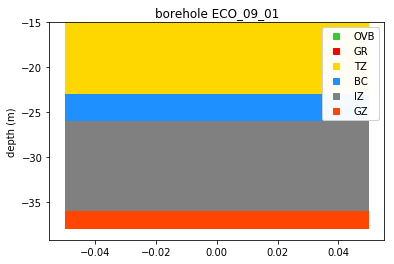

In [35]:
# Geology
bap.plot_borehole(df_Berg_geology, ["ECO_09_01"])

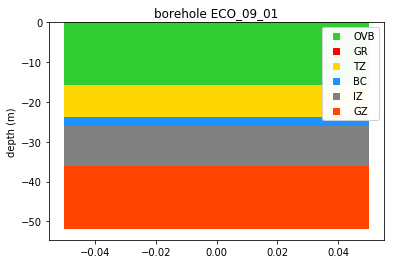

In [36]:
# Washed
bap.plot_borehole(df_Berg_washed, ["ECO_09_01"])

____